# Preserving a multi-variable pointwise quantity of interest (QoI) with safeguards

In this example, we compute the wind kinetic energy per unit mass from a dataset of wind components `u` and `v`. We compare how three different lossy compressors (ZFP, SZ3, and SPERR) affect the derived pointwise kinetic energy when compressing the `u` and `v` variables (stacked into one variable). Finally, we apply safeguards to guarantee an error bound on the derived kinetic energy.

Stacking `u` and `v` into one variable that is then compressed is possible because `u` and `v` have very similar data distributions.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5 = ERA5.sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
def compute_kinetic_energy(ERA5: xr.Dataset) -> xr.DataArray:
    ERA5_KE = 0.5 * (np.square(ERA5["u"]) + np.square(ERA5["v"]))
    ERA5_KE.attrs.update(
        long_name="wind kinetic energy per unit mass", units="m**2 s**-2"
    )

    return ERA5_KE

In [5]:
ERA5_KE = compute_kinetic_energy(ERA5)

In [6]:
def compute_corrections_percentage(my_ERA5: xr.Dataset, orig_ERA5: xr.Dataset) -> float:
    neq = np.sum(my_ERA5 != orig_ERA5)
    return int(neq.u + neq.v) / int(orig_ERA5.u.size + orig_ERA5.v.size)

In [7]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [8]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [9]:
def plot_kinetic_energy(
    my_ERA5: xr.Dataset,
    cr,
    chart,
    title,
    span,
    ke_eb_abs,
    error=False,
    corr=None,
    my_ERA5_it=None,
    cr_it=None,
):
    import copy

    import dask

    my_ERA5_KE = compute_kinetic_energy(my_ERA5)

    if my_ERA5_it is not None:
        my_ERA5_KE_it = compute_kinetic_energy(my_ERA5_it)

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_KE - ERA5_KE).compute()

        err_inf_U = np.amax(np.abs(my_ERA5["u"] - ERA5["u"]))
        err_inf_V = np.amax(np.abs(my_ERA5["v"] - ERA5["v"]))
        err_inf_KE = np.amax(np.abs(my_ERA5_KE - ERA5_KE))
        err_2_KE = np.sqrt(np.mean(np.square(my_ERA5_KE - ERA5_KE)))
        err_v = np.mean(~(np.abs(my_ERA5_KE - ERA5_KE) <= ke_eb_abs))

        if my_ERA5_it is not None:
            err_inf_U_it = np.amax(np.abs(my_ERA5_it["u"] - ERA5["u"]))
            err_inf_V_it = np.amax(np.abs(my_ERA5_it["v"] - ERA5["v"]))
            err_inf_KE_it = np.amax(np.abs(my_ERA5_KE_it - ERA5_KE))
            err_2_KE_it = np.sqrt(np.mean(np.square(my_ERA5_KE_it - ERA5_KE)))
            err_v_it = np.mean(~(np.abs(my_ERA5_KE_it - ERA5_KE) <= ke_eb_abs))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        # plot the square root of kinetic energy to better capture scale
        da = np.sqrt(my_ERA5_KE)
        da.attrs.update(long_name=f"sqrt({da.long_name})", units="m**1 s**-1")

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    if error:
        style._levels = earthkit.plots.styles.levels.Levels(
            np.linspace(-span, span, 22)
        )
        style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
        style._colors = "coolwarm"
    else:
        style._levels = earthkit.plots.styles.levels.Levels(np.linspace(0, span, 22))
        style._legend_kwargs["ticks"] = np.linspace(0, span, 5)
        style._colors = "viridis"

    extend_left = np.nanmin(da) < (-span if error else 0)
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-12)

        with xr.set_options(keep_attrs=True):
            if corr is None:
                da_hatch = np.abs(da) <= ke_eb_abs
            else:
                da_hatch = (my_ERA5["u"] == corr["u"]) & (my_ERA5["v"] == corr["v"])

        da_hatch = da_hatch.copy(
            data=dask.array.from_array(da_hatch.values)
            .rechunk(4)
            .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
            .compute()
        )

        plt.rcParams["hatch.color"] = (
            (0.0, 0.0, 0.0, 0.5) if corr is None else (1.0, 1.0, 1.0, 0.5)
        )
        plt.rcParams["hatch.linewidth"] = 0.5

        chart.contourf(
            x=np.broadcast_to(da_hatch.longitude.values.reshape(1, -1), da_hatch.shape),
            y=np.broadcast_to(da_hatch.latitude.values.reshape(-1, 1), da_hatch.shape),
            z=da_hatch.values,
            colors=["none"],
            levels=[-0.5, 0.9, 1.5],
            hatches=["xxx" if corr is None else "O", None],
            legend_style=None,
            zorder=-11,
        )

        if my_ERA5_it is not None:
            with xr.set_options(keep_attrs=True):
                da_hatch_it = (my_ERA5_it["u"] == corr["u"]) & (
                    my_ERA5_it["v"] == corr["v"]
                )

            da_hatch_it = da_hatch_it.copy(
                data=dask.array.from_array(da_hatch_it.values)
                .rechunk(4)
                .map_blocks(lambda x: np.broadcast_to(np.mean(x), x.shape))
                .compute()
            )

            plt.rcParams["hatch.color"] = (144 / 255, 238 / 255, 144 / 255, 0.5)
            plt.rcParams["hatch.linewidth"] = 0.25

            chart.contourf(
                x=np.broadcast_to(
                    da_hatch_it.longitude.values.reshape(1, -1), da_hatch_it.shape
                ),
                y=np.broadcast_to(
                    da_hatch_it.latitude.values.reshape(-1, 1), da_hatch_it.shape
                ),
                z=da_hatch_it.values,
                colors=["none"],
                levels=[-0.5, 0.9, 1.5],
                hatches=["O", None],
                legend_style=None,
                zorder=-11,
            )
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        if my_ERA5_it is not None:
            corr_it = (
                None
                if corr is None
                else compute_corrections_percentage(my_ERA5_it, corr)
            )

        corr = None if corr is None else compute_corrections_percentage(my_ERA5, corr)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_inf_U:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{v}}}})$={err_inf_V:.02}  "
            + rf"$L_{{{{\infty}}}}(\hat{{{{KE}}}})$={err_inf_KE:.03}  "
            + rf"$L_{{{{2}}}}(\hat{{{{KE}}}})$={err_2_KE:.03}  "
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                )
            )
            + "\n"
            + (
                ""
                if my_ERA5_it is None
                else (
                    "("
                    + rf"$L^{{{{'}}}}_{{{{\infty}}}}(\hat{{{{u}}}})$={err_inf_U_it:.02}  "
                    + rf"$L^{{{{'}}}}_{{{{\infty}}}}(\hat{{{{v}}}})$={err_inf_V_it:.02}  "
                    + rf"$L^{{{{'}}}}_{{{{\infty}}}}(\hat{{{{KE}}}})$={err_inf_KE_it:.03}  "
                    + rf"$L^{{{{'}}}}_{{{{2}}}}(\hat{{{{KE}}}})$={err_2_KE_it:.03}  "
                    + f"V$^{{{{'}}}}$={0 if err_v == 0 else np.format_float_positional(100 * err_v_it, precision=1, min_digits=1) + '%'}"
                    + (
                        ""
                        if corr_it is None
                        else (
                            f"  C$^{{{{'}}}}$={0 if corr == 0 else np.format_float_positional(100 * corr_it, precision=1, min_digits=1) + '%'}"
                        )
                    )
                    + ")"
                )
            )
        )
    else:
        chart.title(f"{title}\n\n")

    if error:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}"
            + ("" if cr_it is None else f" (x {np.round(cr_it, 2)})"),
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(
        da.values.flatten(), range=(-span if error else 0, span), bins=21
    )
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
    cax = cb.ax.inset_axes(
        [
            0.0 - extend_width * extend_left,
            1.25,
            1.0 + extend_width * (0 + extend_left + extend_right),
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    if extend_left:
        cax.bar(
            bins[0] - (bins[1] - bins[0]) / 2,
            height=np.sum(da < (-span if error else 0)),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[0])),
        )
    if extend_right:
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) / 2,
            height=np.sum(da > span),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[-1])),
        )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(
        (-span if error else 0) - (bins[-1] - bins[-2]) * extend_left,
        span + (bins[-1] - bins[-2]) * extend_right,
    )
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

In [10]:
# Since numcodecs-safeguards only supports single-variable safeguarding, we
# stack the u and v variables into a combined variable.
ERA5_UV = np.stack([ERA5["u"].values, ERA5["v"].values], axis=-1)
ERA5.u.dims, ERA5_UV.shape

(('latitude', 'longitude'), (721, 1440, 2))

## Compressing u and v with lossy compressors

We configure each compressor with an absolute error bound of 0.125 m/s over the u-v array, which seems to provide similar errors on the derived kinetic energy.

In [11]:
eb_abs = 0.125

In [12]:
from numcodecs_wasm_zfp import Zfp

zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)

ERA5_UV_zfp_enc = zfp.encode(ERA5_UV)
ERA5_UV_zfp = zfp.decode(ERA5_UV_zfp_enc)

ERA5_zfp = ERA5.copy(data=dict(u=ERA5_UV_zfp[..., 0], v=ERA5_UV_zfp[..., 1]))
ERA5_zfp_cr = ERA5_UV.nbytes / ERA5_UV_zfp_enc.nbytes

In [13]:
from numcodecs_wasm_sz3 import Sz3

sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

ERA5_UV_sz3_enc = sz3.encode(ERA5_UV)
ERA5_UV_sz3 = sz3.decode(ERA5_UV_sz3_enc)

ERA5_sz3 = ERA5.copy(data=dict(u=ERA5_UV_sz3[..., 0], v=ERA5_UV_sz3[..., 1]))
ERA5_sz3_cr = ERA5_UV.nbytes / ERA5_UV_sz3_enc.nbytes

In [14]:
from numcodecs_wasm_sperr import Sperr

sperr = Sperr(mode="pwe", pwe=eb_abs)

ERA5_UV_sperr_enc = sperr.encode(ERA5_UV)
ERA5_UV_sperr = sperr.decode(ERA5_UV_sperr_enc)

ERA5_sperr = ERA5.copy(data=dict(u=ERA5_UV_sperr[..., 0], v=ERA5_UV_sperr[..., 1]))
ERA5_sperr_cr = ERA5_UV.nbytes / ERA5_UV_sperr_enc.nbytes

In [15]:
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

ERA5_UV_zero_enc = zero.encode(ERA5_UV)
ERA5_UV_zero = zero.decode(ERA5_UV_zero_enc)

ERA5_zero = ERA5.copy(data=dict(u=ERA5_UV_zero[..., 0], v=ERA5_UV_zero[..., 1]))

## Compressing u and v using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the pointwise absolute error on the derived kinetic energy, choosing an error bound that is comparible to the errors produced by the lossy compression methods above.

The kinetic energy computation is translated into a quantity of interest. Even though kinetic energy is a pointwise quantity, stacking `u` and `v` into a single variable means that we now compute the kinetic energy over a two-element `(u, v)` local neighbourhood.

In [16]:
ke_eb_abs = 1.0

In [17]:
from numcodecs_safeguards import SafeguardsCodec

ERA5_sg = dict()
ERA5_sg_cr = dict()

for codec in [
    zero,
    zfp,
    sz3,
    sperr,
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="0.5 * (square(X[0]) + square(X[1]))",
                type="abs",
                eb=ke_eb_abs,
                neighbourhood=[
                    dict(axis=-1, before=0, after=1, boundary="valid"),
                ],
            )
        ],
    )

    ERA5_UV_sg_enc = sg.encode(ERA5_UV)
    ERA5_UV_sg = sg.decode(ERA5_UV_sg_enc)

    ERA5_sg[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg[..., 0], v=ERA5_UV_sg[..., 1])
    )
    ERA5_sg_cr[codec.codec_id] = ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_enc).nbytes

In [18]:
ERA5_sg_it = dict()
ERA5_sg_it_cr = dict()

for codec in [
    ZeroCodec(),
    zfp,
    sz3,
    sperr,
]:
    sg_it = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(
                kind="qoi_eb_stencil",
                qoi="0.5 * (square(X[0]) + square(X[1]))",
                type="abs",
                eb=ke_eb_abs,
                neighbourhood=[
                    dict(axis=-1, before=0, after=1, boundary="valid"),
                ],
            )
        ],
        # use iteration to refine the corrections
        compute=dict(_unstable_iterative=True),
    )

    ERA5_UV_sg_it_enc = sg_it.encode(ERA5_UV)
    ERA5_UV_sg_it = sg_it.decode(ERA5_UV_sg_it_enc)

    ERA5_sg_it[codec.codec_id] = ERA5.copy(
        data=dict(u=ERA5_UV_sg_it[..., 0], v=ERA5_UV_sg_it[..., 1])
    )
    ERA5_sg_it_cr[codec.codec_id] = (
        ERA5_UV.nbytes / np.asarray(ERA5_UV_sg_it_enc).nbytes
    )

## Visual comparison of the error distributions for the derived kinetic energy

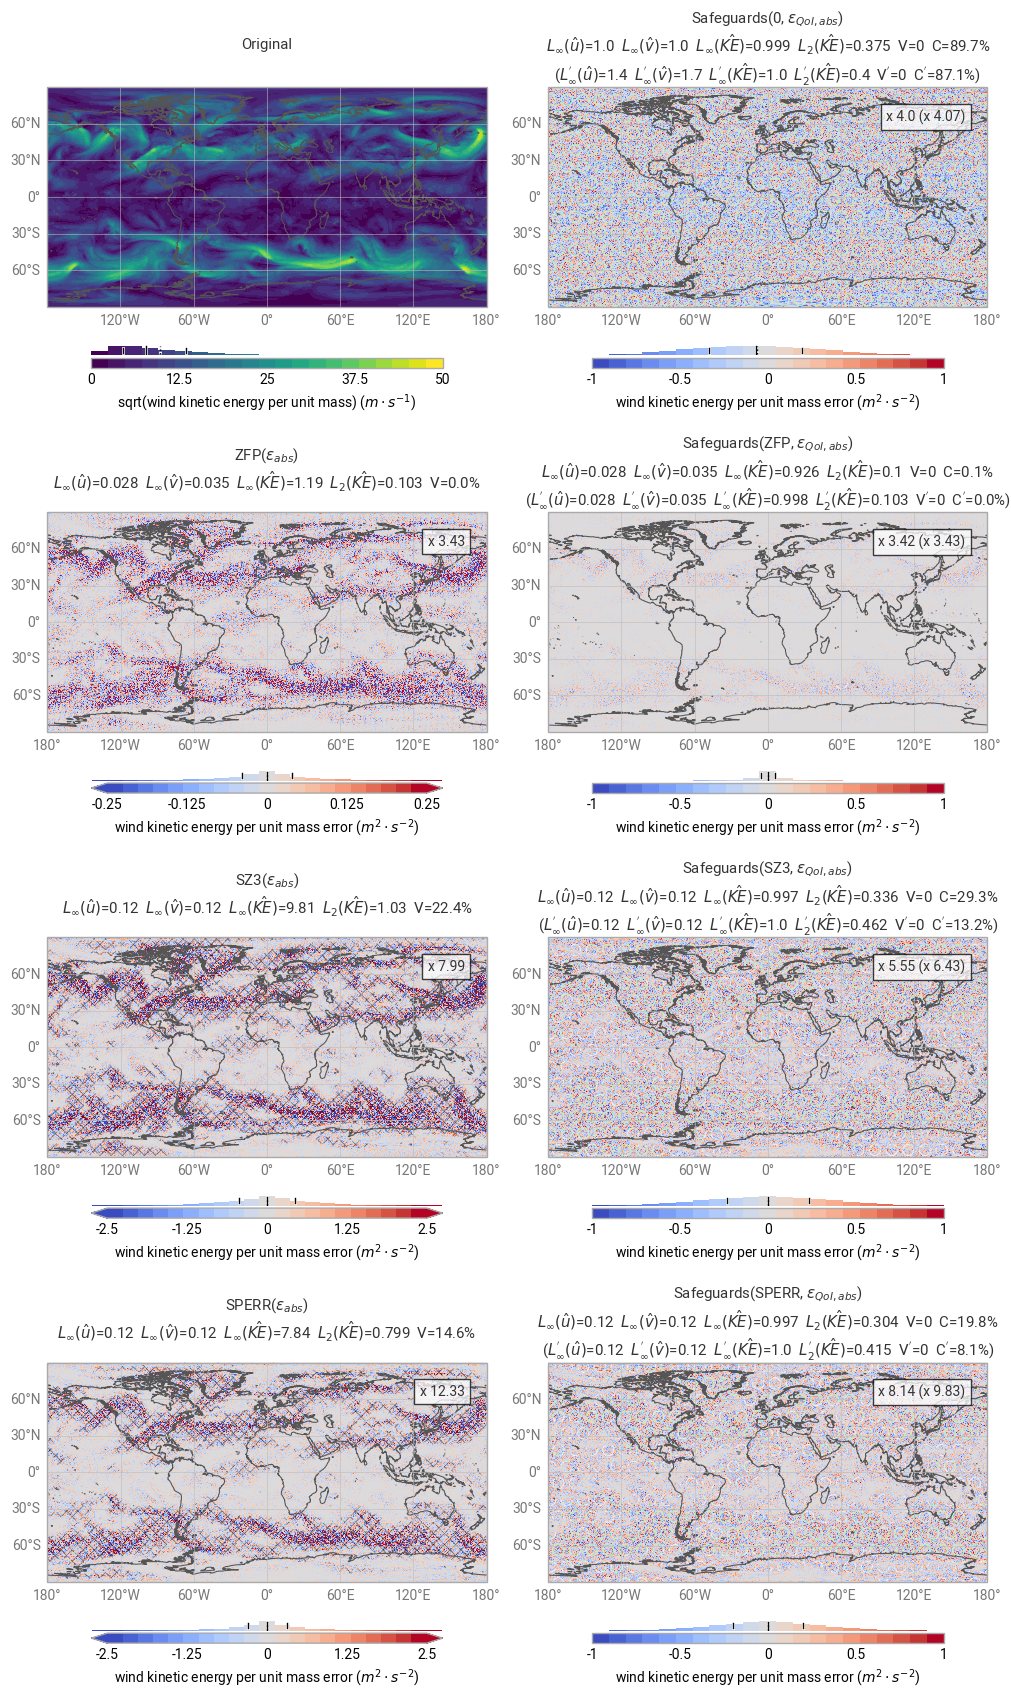

In [19]:
fig = earthkit.plots.Figure(
    size=(10, 17),
    rows=4,
    columns=2,
)

plot_kinetic_energy(
    ERA5, 1.0, fig.add_map(0, 0), "Original", span=50, ke_eb_abs=ke_eb_abs
)
plot_kinetic_energy(
    ERA5_zfp,
    ERA5_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    span=0.25,
    ke_eb_abs=ke_eb_abs,
    error=True,
)
plot_kinetic_energy(
    ERA5_sz3,
    ERA5_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    span=2.5,
    ke_eb_abs=ke_eb_abs,
    error=True,
)
plot_kinetic_energy(
    ERA5_sperr,
    ERA5_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    span=2.5,
    ke_eb_abs=ke_eb_abs,
    error=True,
)

plot_kinetic_energy(
    ERA5_sg["zero"],
    ERA5_sg_cr["zero"],
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
    corr=ERA5_zero,
    my_ERA5_it=ERA5_sg_it["zero"],
    cr_it=ERA5_sg_it_cr["zero"],
)
plot_kinetic_energy(
    ERA5_sg["zfp.rs"],
    ERA5_sg_cr["zfp.rs"],
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
    corr=ERA5_zfp,
    my_ERA5_it=ERA5_sg_it["zfp.rs"],
    cr_it=ERA5_sg_it_cr["zfp.rs"],
)
plot_kinetic_energy(
    ERA5_sg["sz3.rs"],
    ERA5_sg_cr["sz3.rs"],
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
    corr=ERA5_sz3,
    my_ERA5_it=ERA5_sg_it["sz3.rs"],
    cr_it=ERA5_sg_it_cr["sz3.rs"],
)
plot_kinetic_energy(
    ERA5_sg["sperr.rs"],
    ERA5_sg_cr["sperr.rs"],
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$)",
    span=ke_eb_abs,
    ke_eb_abs=ke_eb_abs,
    error=True,
    corr=ERA5_sperr,
    my_ERA5_it=ERA5_sg_it["sperr.rs"],
    cr_it=ERA5_sg_it_cr["sperr.rs"],
)

fig.save("kinetic-energy.pdf")